## クエリ拡張を試してみる

In [1]:
import faiss
import numpy as np
from joblib import load

from src.const import OUTPUT_ROOT, QUERY_IMAGES_PATH, CITE_IMAGES_PATH
from src.data_handler import load_trainable_df
from src.utils import l2norm_numpy

## Config

In [11]:
class Config:
    target_path_root = OUTPUT_ROOT / 'train_arcface_with_label_smoothing' / 'outputs' / 'NENet_L0_768_rotate' / 'predictions'
    cite_pkl =  target_path_root / 'cite_embeddings.pkl'
    test_embedding_pkl = target_path_root / 'test_embeddings.pkl'
    output = OUTPUT_ROOT / 'post_process' / 'dbm' / 'nfnet_rotate'
    output.mkdir(parents=True, exist_ok=True)

## データのロード

In [12]:
(train_df, test_df, cite_df, sample_submission_df) = load_trainable_df()
cite_embeddings, test_embeddings = load(Config.cite_pkl), load(Config.test_embedding_pkl)
cite_embeddings['embeddings_mean'] = np.mean(
    cite_embeddings['embeddings_list'],
    axis=0
)
test_embeddings['embeddings_mean'] = np.mean(
    test_embeddings['embeddings_list'],
    axis=0
)
train_df.shape

(108160, 7)

## クエリ拡張実施

In [13]:
def dbaug(test_embeddings, cite_embeddings, k=2, alpha=1.0):
    # l2正規化
    test_embeddings = l2norm_numpy(test_embeddings)
    cite_embeddings = l2norm_numpy(cite_embeddings)
    # testと参照埋め込みを結合
    concat_embeddings = np.concatenate([test_embeddings, cite_embeddings], axis=0).astype(np.float32)
    n_dim = concat_embeddings.shape[1]
    # 類似度の計算
    res = faiss.StandardGpuResources()
    index = faiss.IndexFlatIP(n_dim)
    index = faiss.index_cpu_to_gpu(res, 0, index)
    index.add(concat_embeddings)
    sims, topk_idx = index.search(x=concat_embeddings, k=k)
    # 類似度に対応した重みで埋め込みを更新
    weights = sims ** alpha
    embeddings_tmp = np.zeros(concat_embeddings.shape)
    for i in range(concat_embeddings.shape[0]):
        embeddings_tmp[i, :] = weights[i].dot(concat_embeddings[topk_idx[i]])
    concat_embeddings = l2norm_numpy(embeddings_tmp)
    # test, 参照埋め込みを元に戻す
    split_at = [len(test_embeddings)]
    test_embeddings, cite_embeddings = np.split(concat_embeddings, split_at, axis=0)
    return test_embeddings, cite_embeddings

In [14]:
test_embeddings, cite_embeddings = test_embeddings['embeddings_mean'], cite_embeddings['embeddings_mean']
for _ in range(1):
    test_embeddings, cite_embeddings = dbaug(test_embeddings, cite_embeddings)

In [15]:
IDX2CITE_GID = cite_df.to_dict()["gid"]

In [16]:
class SimilaritySearcher:
    def __init__(self, embeddings):
        self.dimension = embeddings.shape[1]
        self.index = faiss.IndexFlatL2(self.dimension)
        faiss.normalize_L2(embeddings)
        self.index.add(embeddings)  # type:ignore

    def search(self, queries, k=10):
        assert queries.shape[1] == self.dimension, "Query dimensions should match embeddings dimension."
        faiss.normalize_L2(queries)
        D, I = self.index.search(queries, k)  # type:ignore
        return D, I


def make_submission(indices):
    vfunc = np.vectorize(lambda x: IDX2CITE_GID[x])
    gid_array = vfunc(I)
    submission_df = test_df[["gid"]].assign(cite_gid=[" ".join(list(x)) for x in gid_array.astype(str)])
    return submission_df

In [17]:
searcher = SimilaritySearcher(cite_embeddings.astype(np.float32))
D, I = searcher.search(test_embeddings.astype(np.float32), k=20)

In [18]:
submission_df = make_submission(indices=I)
submission_df.to_csv(Config.output / "submission.csv", index=False)

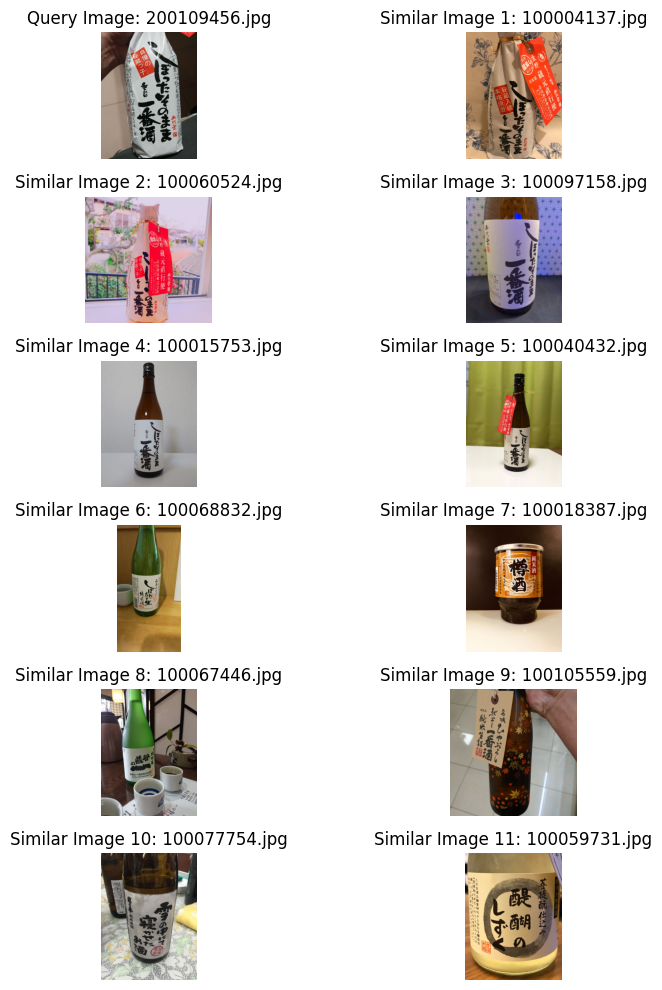

In [19]:
import cv2
import matplotlib.pyplot as plt

def display_similar_images(query_path, cite_paths):
    num_similar = len(cite_paths)

    # Query画像の読み込み
    query_image = cv2.imread(query_path)
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)

    # 類似画像の読み込みと表示
    num_rows = (num_similar + 1) // 2
    fig, axs = plt.subplots(num_rows, 2, figsize=(10, 10), squeeze=False)

    axs[0, 0].imshow(query_image)
    axs[0, 0].set_title(f'Query Image: {query_path.split("/")[-1]}')
    axs[0, 0].axis('off')

    for i, path in enumerate(cite_paths):
        similar_image = cv2.imread(path)
        similar_image = cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB)

        axs[(i+1)//2, (i+1)%2].imshow(similar_image)
        axs[(i+1)//2, (i+1)%2].set_title(f'Similar Image {i+1}: {path.split("/")[-1]}')
        axs[(i+1)//2, (i+1)%2].axis('off')

    # 空白のsubplotを削除
    if num_similar % 2 != 0:
        axs[num_rows-1, 1].axis('off')

    plt.tight_layout()
    plt.show()


def get_qyery_and_cite_path(submission_df, query_gid=None, k=4):
    if query_gid is None:
        query_gid = submission_df["gid"].sample(1).to_numpy()[0]

    cites = submission_df.loc[submission_df["gid"] ==query_gid, "cite_gid"].to_numpy()[0].split(" ")[:k]

    query_path = QUERY_IMAGES_PATH / f"{query_gid}.jpg"
    cite_paths = [(CITE_IMAGES_PATH / f"{cite_gid}.jpg").as_posix() for cite_gid in cites]
    return {"query_path":query_path.as_posix(), "cite_paths":cite_paths}


def plot_sake(submission_df, query_gid=None, k=11):
    path_dict = get_qyery_and_cite_path(submission_df, query_gid=query_gid, k=k)
    display_similar_images(**path_dict)


plot_sake(submission_df, query_gid=None)